In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
#os.chdir("C:/Users/Nikita/Documents/GitHub/Self-learning-Monte-carlo-algorithms")
#os.chdir("C:/aut/Self-learning-Monte-carlo-algorithms")
import Ising
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.style.use('ggplot')

## Square lattice

In [43]:
test_ising = Ising.Ising(16, 16)
test_ising.lattice = np.array([16*[1] for i in range(16)])

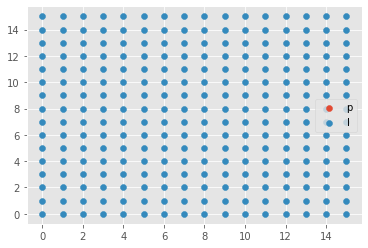

In [44]:
test_ising.show()

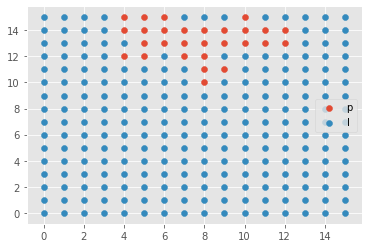

In [45]:
test_ising.cluster_ising(1-np.exp(-1/4 * 2))
test_ising.show()

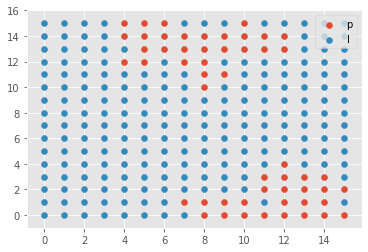

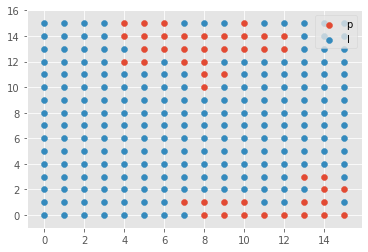

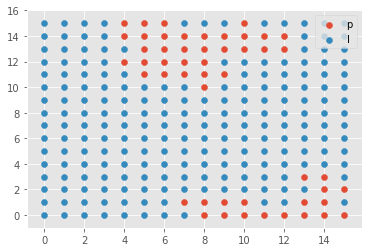

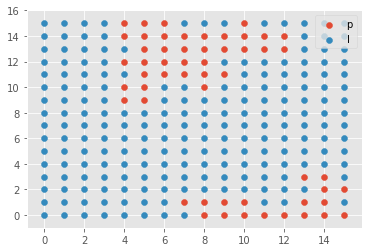

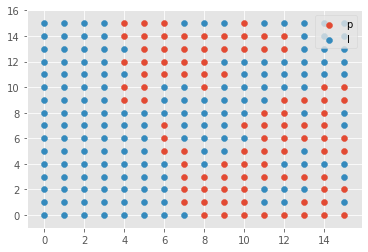

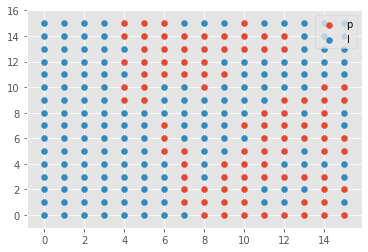

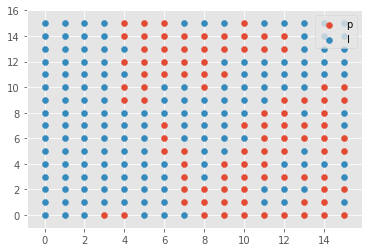

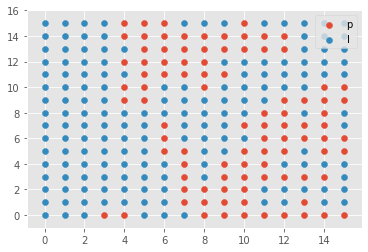

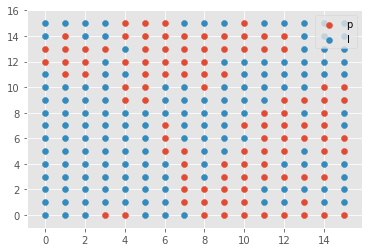

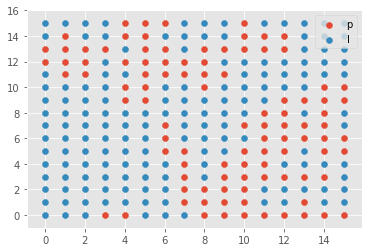

In [46]:
for _ in range(10):
    test_ising.cluster_ising(1-np.exp(-1/4 * 2))
    test_ising.show()

In [3]:
# Train data generation
train = Ising.Ising(10, 10)
x = np.arange(1, 3.5, 0.0625)
label = []
curr_label = 0
X_train = []
var = []
y = []
N = 10**4
for T in tqdm(x):
    mag = []
    if T >= 2.266:
        curr_label = 0
    else :
        curr_label = 1
    for i in tqdm(range(N)):
        train.cluster_ising(1-np.exp(-(1/T)*2))
    for _ in tqdm(range(1000)):
        for _ in range(100):
            train.cluster_ising(1-np.exp(-(1/T)*2))
        mag.append(train.magnetism())
        X_train.append(np.array(train.lattice.reshape((1, train.y*train.x))[0]))
        label.append(curr_label)
    mn = np.mean(mag)
    y.append(mn)
    var.append(np.std(mag))

KeyboardInterrupt: 

In [8]:
# Save
#np.save("./Data/data_size10_min1_max3.5_steap0.0625_batch1000_re100_N10000", X_train)
#np.save("./Data/labels_size10_min1_max3.5_steap0.0625_batch1000_re100_N10000", label)

In [ ]:
# Save 20x20
np.save("./Data/data_size20_min1_max3.5_steap0.0625_batch1000_re100_N10000", X_train)
np.save("./Data/labels_size20_min1_max3.5_steap0.0625_batch1000_re100_N10000", label)

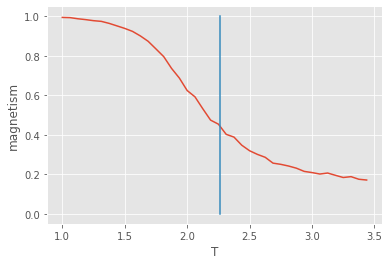

In [9]:
#С рандомными
plt.plot(x, y)
plt.xlabel("T")
plt.ylabel("magnetism")

x_line = np.arange(0,1.1, 0.1)
plt.plot([2.266]*x_line.shape[0], x_line, '-')

## Training

In [59]:
# load
X = np.load("./Data/data_size10_min1_max3.5_steap0.0625_batch1000_re100_N10000.npy")
label = np.load("./Data/labels_size10_min1_max3.5_steap0.0625_batch1000_re100_N10000.npy")
x = np.arange(1, 3.5, 0.0625)

In [60]:
X[20002].mean()

0.16

In [61]:
X = np.array(X) 

In [62]:
x_cat = np.array([[i]*1000 for i in x])

In [63]:
X = np.concatenate((X, x_cat.reshape(-1,1)), axis=1)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.05)

In [65]:
X_train_time = X_train[:, -1]
X_test_time = X_test[:, -1]

In [66]:
X_train = X_train[:, :X_train.shape[1]-1]
X_test = X_test[:, :X_test.shape[1]-1]

In [67]:
X_train = np.array(X_train)
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(np.array(y_train))

In [68]:
X_test = np.array(X_test)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(np.array(y_test))

In [80]:
class Net(torch.nn.Module):
    def __init__(self, input_size=10*10, hidden_size=100):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.act = torch.nn.ReLU()
        #self.drop = torch.nn.Dropout()
        self.fc2 = torch.nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        #x = self.drop(x)
        x = self.fc2(x)
        return x


net = Net()

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [14]:
net = net.to(device)

In [15]:
device

device(type='cpu')

In [73]:
X_test = np.array(X_test)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(np.array(label))

C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


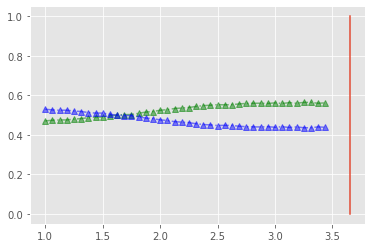

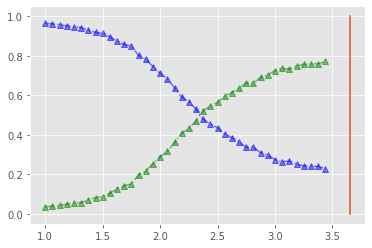

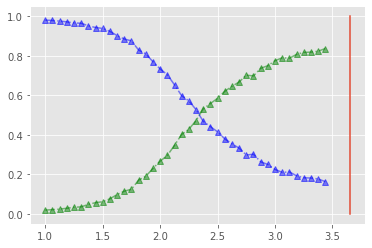

KeyboardInterrupt: 

In [81]:
cr = torch.nn.Softmax()
criterion = torch.nn.CrossEntropyLoss()
lr=0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
for e in range(400):
    net.train()
    output = net.forward(X_train.float())
    loss = criterion(output, y_train.long())
    loss.backward()
    optimizer.step()
    net.zero_grad()
    
    if e % 100 == 0:
        net.eval()
        output_val = net.forward(X_test.float())
        print(e, ":", "val accuracy:", 
              ((np.around(cr(output_val)[:, 1].detach().numpy()) == y_test.detach().numpy()).sum())/y_test.detach().numpy().shape[0],
             "train accuracy:", ((np.around(cr(output)[:, 1].detach().numpy()) == y_train.detach().numpy()).sum())/y_train.detach().numpy().shape[0])
        
        output_soft = cr(output).detach().numpy()
        output_val_soft = cr(output_val).detach().numpy()
        x_line = np.arange(0,1.2,0.2)
        output_0 = []
        for T in np.unique(X_test_time):
            indexes = np.where(X_test_time == T)
            output_0.append(output_val_soft[:, 0][indexes].mean())
        plt.plot(x, output_0, '-.^g', alpha=0.5)
        output_1 = []
        for T in np.unique(X_test_time):
            indexes = np.where(X_test_time == T)
            output_1.append(output_val_soft[:, 1][indexes].mean())
        plt.plot(x, output_1, '-.^b', alpha=0.5)
        plt.plot([2.266]*x_line.shape[0], x_line, '-')
        plt.show()

In [24]:
net.eval()

Net(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [17]:
output = net.forward(X_train.float())
output_val = net.forward(X_test.float())
output_soft = cr(output).detach().numpy()
output_val_soft = cr(output_val).detach().numpy()

C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


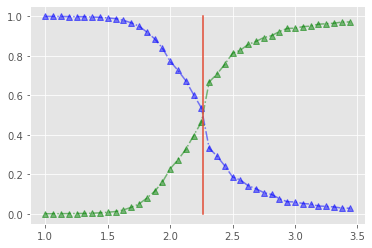

In [100]:
x_line = np.arange(0,1.2,0.2)
output_0 = []
for T in np.unique(X_train_time):
    indexes = np.where(X_train_time == T)
    output_0.append(output_soft[:, 0][indexes].mean())
plt.plot(x, output_0, '-.^g', alpha=0.5)
output_1 = []
for T in np.unique(X_train_time):
    indexes = np.where(X_train_time == T)
    output_1.append(output_soft[:, 1][indexes].mean())
plt.plot(x, output_1, '-.^b', alpha=0.5)
plt.plot([2.266]*x_line.shape[0], x_line, '-')

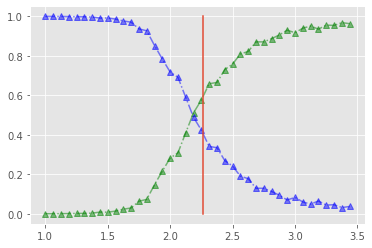

In [101]:
x_line = np.arange(0,1.2,0.2)
output_0 = []
for T in np.unique(X_test_time):
    indexes = np.where(X_test_time == T)
    output_0.append(output_val_soft[:, 0][indexes].mean())
plt.plot(x, output_0, '-.^g', alpha=0.5)
output_1 = []
for T in np.unique(X_test_time):
    indexes = np.where(X_test_time == T)
    output_1.append(output_val_soft[:, 1][indexes].mean())
plt.plot(x, output_1, '-.^b', alpha=0.5)
plt.plot([2.266]*x_line.shape[0], x_line, '-')

In [107]:
yy = y_test.detach().numpy()
xx = np.around(cr(output_val)[:, 1].detach().numpy())
count = 0
for i in range(len(xx)):
    if xx[i] != yy[i]:
        print(X_test_time[i], X_test[i].mean(), xx[i], yy[i])
        count +=1
  

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


2.0625 -1.0
2.5 1.0
2.0 -1.0
2.25 -1.0
1.875 1.0
1.8125 -1.0
2.25 -1.0
1.9375 1.0
2.25 1.0
2.1875 1.0
2.4375 -1.0
2.0625 -1.0
2.0 -1.0
2.375 -1.0
2.1875 -1.0
2.0 -1.0
2.1875 -1.0
1.9375 -1.0
2.25 -1.0
2.3125 1.0
2.25 1.0
2.125 1.0
2.25 -1.0
2.25 -1.0
2.3125 -1.0
2.0 -1.0
1.9375 -1.0
2.375 -1.0
2.25 -1.0
1.9375 -1.0
3.0 -1.0
2.25 -1.0
2.25 -1.0
2.0625 1.0
2.5 -1.0
1.875 -1.0
2.0625 1.0
2.25 0.98
2.1875 1.0
2.0 -1.0
2.0 1.0
1.75 -1.0
2.25 -1.0
2.75 1.0
2.125 1.0
2.1875 1.0
2.375 1.0
1.9375 1.0
2.25 -1.0
2.1875 -1.0
2.125 -1.0
2.5 -1.0
2.1875 -1.0
2.375 -1.0
2.1875 1.0
2.125 0.98
2.125 -1.0
2.75 -1.0
2.0 -1.0
2.5625 -1.0
2.3125 -1.0
2.8125 -1.0
2.0 1.0
2.125 1.0
2.8125 0.98
1.9375 1.0
2.1875 1.0
1.8125 1.0
2.125 1.0
2.1875 -1.0
2.0625 -1.0
2.0625 0.98
2.1875 1.0
1.875 -1.0
1.75 1.0
2.375 -1.0
2.5 1.0
2.125 1.0
2.375 -1.0
2.25 -1.0
2.0 -1.0
1.9375 -1.0
2.0 1.0
2.375 -1.0
2.3125 -1.0
2.0 -1.0
2.25 1.0
2.1875 -0.98
2.125 -1.0
2.0625 -1.0
2.3125 -1.0
2.4375 1.0
2.25 -1.0
2.8125 1.0
2.125 1.0


In [109]:
xx = torch.from_numpy(np.array([-1]*100))
cr(net.forward(xx.float()))

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor([4.9170e-04, 9.9951e-01], grad_fn=<SoftmaxBackward>)

## Triangular lattice

In [ ]:
# triangular Test data generation
test = Ising.Ising(10, 10)
x = np.arange(2, 5.5, 0.0625)
label = []
curr_label = 1
X_test = []
var = []
y = []
N = 10**2
for T in tqdm(x):
    mag = []
    if T >= 3.65:
        curr_label = 0
    else :
        curr_label = 1
    for i in (range(N)):
        test.cluster_ising(1-np.exp(-(1/T)*2), "triangular")
    for _ in tqdm(range(100)):
        for _ in range(10):
            test.cluster_ising(1-np.exp(-(1/T)*2), "triangular")
        mag.append(test.magnetism())
        X_test.append(np.array(test.lattice.reshape((1, test.y*test.x))[0]))
        label.append(curr_label)
    mn = np.mean(mag)
    y.append(mn)
    var.append(np.std(mag))

In [5]:
# Save
#np.save("./Data/data_size10_min1_max3.5_steap0.0625_batch1000_re100_N10000_triangular", X_test)
#np.save("./Data/labels_size10_min1_max3.5_steap0.0625_batch1000_re100_N10000_triangular", label)

In [71]:
# load
X_test = np.load("./Data/data_size10_min1_max3.5_steap0.0625_batch1000_re100_N10000_triangular.npy")
label = np.load("./Data/labels_size10_min1_max3.5_steap0.0625_batch1000_re100_N10000_triangular.npy")

In [78]:
N = 10**3

In [19]:
y = []
X_test = np.array(X_test)
N = X_test.shape[0]//56
for i in range(56):
    curr = X_test[(i)*N:(i+1)*N]
    mn = []
    for i in curr:
        mn.append(np.abs(i.mean()))
    y.append(np.mean(mn))

In [82]:
x = np.arange(2, 5.5, 0.0625)

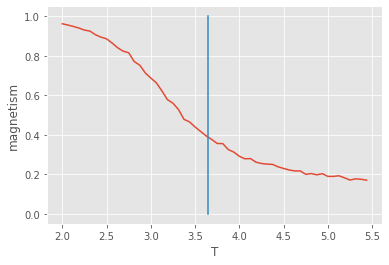

In [20]:
x = np.arange(2, 5.5, 0.0625)
plt.plot(x, y)
plt.xlabel("T")
plt.ylabel("magnetism")

x_line = np.arange(0,1.1, 0.1)
plt.plot([3.65]*x_line.shape[0], x_line, '-')

In [21]:
X_test = np.array(X_test)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(np.array(label))

In [22]:
output_val = net.forward(X_test.float())
output_val_soft = cr(output_val).detach().numpy()

C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [23]:
((np.around(cr(output_val)[:, 1].detach().numpy()) == y_test.detach().numpy()).sum())/y_test.detach().numpy().shape[0]

C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


0.8800357142857143

In [24]:
output_val_soft

array([[0.00419895, 0.99580103],
       [0.00179714, 0.9982028 ],
       [0.00696862, 0.9930314 ],
       ...,
       [0.9908037 , 0.00919625],
       [0.99726236, 0.00273761],
       [0.9982838 , 0.00171622]], dtype=float32)

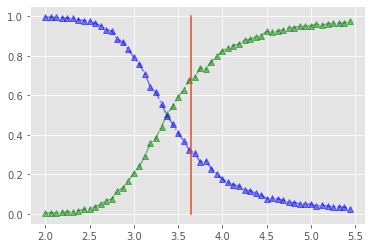

In [26]:
x_line = np.arange(0,1.2,0.2)
output_0 = []
for i in range(x.shape[0]):
    output_0.append(output_val_soft[:, 0][i*N:(i+1)*N].mean())
plt.plot(x, output_0, '-.^g', alpha=0.5)
output_1 = []
for i in range(x.shape[0]):
    output_1.append(output_val_soft[:, 1][i*N:(i+1)*N].mean())
plt.plot(x, output_1, '-.^b', alpha=0.5)
plt.plot([3.65]*x_line.shape[0], x_line, '-')

C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


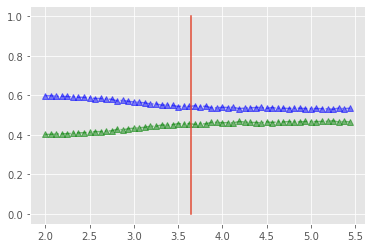

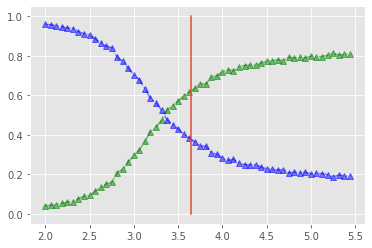

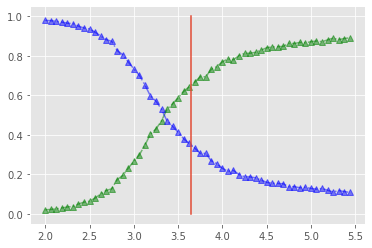

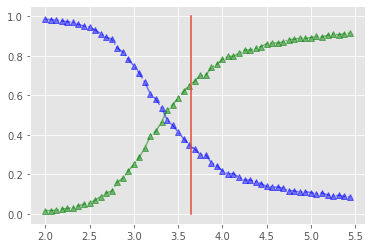

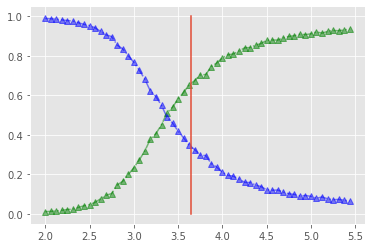

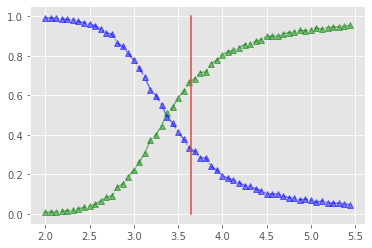

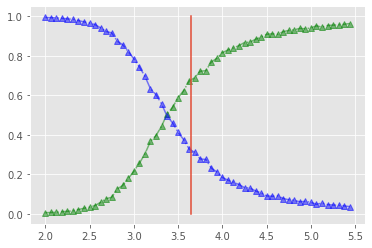

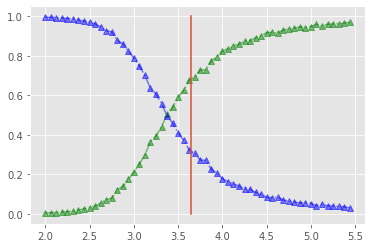

In [84]:
net = Net()
cr = torch.nn.Softmax()
criterion = torch.nn.CrossEntropyLoss()
lr=0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
for e in range(400):
    net.train()
    output = net.forward(X_train.float())
    loss = criterion(output, y_train.long())
    loss.backward()
    optimizer.step()
    net.zero_grad()
    
    if e % 50 == 0:
        net.eval()
        output_val = net.forward(X_test.float())
        output_val_soft = cr(output_val).detach().numpy()
        x_line = np.arange(0,1.2,0.2)
        output_0 = []
        for i in range(x.shape[0]):
            output_0.append(output_val_soft[:, 0][i*N:(i+1)*N].mean())
        plt.plot(x, output_0, '-.^g', alpha=0.5)
        output_1 = []
        for i in range(x.shape[0]):
            output_1.append(output_val_soft[:, 1][i*N:(i+1)*N].mean())
        plt.plot(x, output_1, '-.^b', alpha=0.5)
        plt.plot([3.65]*x_line.shape[0], x_line, '-')
        plt.show()